# MPO Creation
Algorithm: Given an operator $\rho_{i,j}\left|i\right>\left<j\right|$ with indices $i,j\in\mathbb Z_d^n$:

1. Reshape: $\rho_{i,j}= P_{(i_1\cdots i_n),(j_1\cdots j_n)}$ has dimensions $d^n\times d^n$
2. Permute: $P_{(i_1\cdots i_n),(j_1\cdots j_n)}= T_{(i_1j_1),\cdots ,(i_nj_n)}$ has dimensions $d^2\times\cdots \times d^2$ ($n$ times)
3. Collect: $T_{(i_1j_1),(i_2j_2\cdots i_nj_n)}$ has dimensions $d^2\times d^{2(n-1)}$
4. First site:
	- SVD: $T_{(i_1j_1),(i_2j_2\cdots i_nj_n)}=\sum_{\alpha\in \mathbb Z_{D_1}} U_{(i_1j_1),\alpha}S_{\alpha,\alpha} (V^\dagger)_{\alpha,(i_2j_2\cdots i_nj_n)}$, where $D_1\in \{1,\cdots,d^2\}$ is determined by truncation 
	- Save: $M^{(1)}_{\alpha,u,\beta}=\delta_{\alpha,1}U_{u,\beta}$ has dimensions $1\times d^2\times D_1$
	- Update: $T^{(1)}_{(\alpha i_2j_2),(i_3j_3\cdots i_nj_n)}=S_{\alpha,\alpha}(V^\dagger)_{\alpha,(i_2j_2\cdots i_nj_n)}$ has dimensions $D_1 d^2\times d^{2(n-2)}$
5. Inner sites: For $k\in \{2,\cdots,n-1\}$:
	- SVD: $T^{(k)}_{(\alpha i_kj_k),(i_{k+1}j_{k+1}\cdots i_nj_n)}=\sum_{\beta\in \mathbb Z_{D_k}} U_{(\alpha i_kj_k),\beta}S_{\beta,\beta} (V^\dagger)_{\beta,(i_{k+1}j_{k+1}\cdots i_nj_n)}$, where $D_k\in\{1,\cdots,D_{k-1}d^2\}$
	- Save: $M^{(k)}_{\alpha,u,\beta}=U_{(\alpha u),\beta}$ has dimensions $D_{k-1}\times d^2\times D_k$
	- Update: $T_{(\alpha i_{k+1}j_{k+1}),(i_{k+2}j_{k+2}\cdots i_nj_n)}=S_{\alpha,\alpha} (V^\dagger)_{\alpha,(i_{k+1}j_{k+1}\cdots i_nj_n)}$ has dimensions $D_k d^2\times d^{2(n-k-1)}$
6. Last site:
	- Save: $M^{(n)}_{\alpha,u,\beta}=T^{(n-1)}_{(\alpha,u),\beta}$ has dimensions $D_{n-1}\times d^2\times 1$ (note that $T^{(n-1)}_{(\alpha i_nj_n),\beta}$ has dimensions $D_{n-1} d^2\times 1$)
7. Return $\{M^{(k)}\}_{k\in\mathbb Z_n}$

These steps are implemented in mpo_algorithms.py:

In [2]:
import mpo_algorithms as mpo

We can run this algorithm on a randomly generated density matrix, which we can get using random_state_gen.py:

In [3]:
import random_state_gen as rand

I should expect to see the following dimensions of my matrices and local tensor after performing each SVD for $d=3,n=5$: The density matrix has dimensions $3^5\times 3^5$ and the environment tensor $T$ starts out with dimensions $9\times 9^4$. After each step, we should expect $D_k$ to start at 1 and increase by a factor of 9 until we hit the middle site, and then decrease by a factor of 9 back down to 1 until the final site:

In [4]:
d = 3
n = 2
rho = rand.random_mixed_state(n,d)
m_rho = mpo.state_to_mpo(rho,n,d,verbose=True)

0 Initial T:				 (9, 9)
1 (9, 9) (9, 9) 	-> (1, 9, 9) 	 (81, 1) 	 9
2 Final Matrix:		   (9, 9, 1)


To check that the MPO procedure returned an operator corresponding to the same operator which we input into the algorithm, we can use numpy's unravel_index method to compute each matrix element and check:

In [5]:
mpo.check_coefficients(m_rho, rho, n, d)

True


# Inner products
The Frobenius norm overlap between two operators is defined to be
$$\left<\rho|\sigma\right>=\mathrm{Tr}\left[\rho^\dagger\sigma\right]=\sum_u \left(\prod_i \rho^{(i)u_i}\right)^*\left(\prod_j \sigma^{(i)u_j}\right),$$
where $*$ denotes element-wise complex conjugation. This can be calculated in a linear number of computations in $d$ and $n$ and cubic in $D^\sigma$ and $D^\rho$ like so:
1. $M_{\alpha\beta} = \sum_{u\in \mathbb Z_d}(\rho^{(1)}_{1u\alpha})^*\sigma^{(1)}_{1u\beta}$
2. For $k\in\{2,\cdots,n\}:$
    - $M_{\alpha\beta}\leftarrow \sum_{u\in \mathbb Z_d,\mu\in\mathbb Z_{D^\rho_k},\mu\in\mathbb Z_{D^\sigma_k}}(\rho^{(k)}_{\mu u \alpha})^*M_{\mu \nu}\sigma^{(k)}_{\nu u \beta}$
3. Return $M_{11}$

Note that the matrix elements are stored like so: $\rho^{(k)u}_{\alpha\beta}=\rho^{(k)}_{\alpha u \beta}$, and $D^\rho_k$ denotes the bond dimension of $\rho^{(k)}$ at site $k$.

This is implemented in mpo_algorithms.py, and we can check that it works like so:

In [6]:
import numpy as np
print(np.absolute(mpo.inner_prod(m_rho,m_rho) - np.trace(np.dot(rho.conj().T,rho))) < 1e-14)

True


## Moving to phase space

We formed our MPO like so: $\rho_{ij}\left|i\right>\left<j\right|=\rho_{(i_1\cdots i_n)(j_1\cdots j_n)}(\left|i_1\right>\otimes \cdots \otimes \left|i_n\right>)(\left<j_1\right|\otimes \cdots \otimes \left<j_n\right|)=\sum_{i_kj_k\alpha _k}\rho^{(1)}_{\alpha_0(i_1j_1)\alpha_1}\left|i_1\right>\left<j_1\right|\otimes\cdots\otimes \rho^{(n)}_{\alpha_{n-1}(i_nj_n)\alpha_n}\left|i_n\right>\left<j_n\right|$. This gave us a matrix product operator of the form $\sum_{u,\alpha} \otimes_k \rho^{(k)u_k}_{\alpha_k\alpha_{k+1}}C_{u_k}$, where $C_u=C_{du_1+u_2}=\left|u_1\right>\left<u_2\right|$. We want to represent it in phase space, i.e. we want to find the MPO $\tilde{\rho}$ satisfying $\sum_{u,\alpha} \otimes_k \rho^{(k)u_k}_{\alpha_k\alpha_{k+1}} C_{u_k}=\sum_{u,\alpha} \otimes_k \tilde{\rho}^{(k)u_k}_{\alpha_k\alpha_{k+1}} A_{u_k}$. Taking the Frobenius inner product with $A_v$ on both sides of this equation shows that the following choice works:

$$\tilde{\rho}^{(k)u}_{\alpha\beta}=d^{-1}\sum_v\rho^{(k)v}_{\alpha\beta}\mathrm{Tr}\left[C_uA_v\right]=d^{-1}\sum_v\rho^{(k)v}_{\alpha\beta}(A_v)_{u_1,u_2}$$

The last equality arises because $\mathrm{Tr}[C_u A_v]=\sum_k \left<k|u_1\right>\left<u_2|A_v |k\right>=\left<u_1|A_v|u_2\right>=(A_v)_{u_1,u_2}$, so the change-of-basis coefficients are proportional to the matrix elements of the phase space operators. 

Since $\mathrm{Tr}[A_uA_v]=d\delta_{u,v}$, the phase space basis is not normalized. This means that we pick up a Hilbert space factor when computing inner products:

$$\mathrm{Tr}[\rho^\dagger \sigma]=d^n\left<\rho|\sigma\right>_A,$$

where $\left<\rho|\sigma\right>_A$ denotes the contraction of the matrix product representations of the states $\rho$ and $\sigma$ in the phase space basis $A_u$. This basis change is implemented in wigner.py:

In [7]:
import wigner

Some checks to make sure that we did the change of basis correctly:

In [8]:
# Check that phase space elements satisfy expected properties
wigner.basic_checks(d)

# Check that inner product in new basis agrees with old basis
m_rho_ps = wigner.basis_change(m_rho, wigner.ps_coefficients)
if (abs(mpo.inner_prod(m_rho_ps,m_rho_ps,norm=d**n).imag) > 1e-12):
    print("Inner product in new basis is imaginary")
if (abs(mpo.inner_prod(m_rho_ps,m_rho_ps,norm=d**n).real - mpo.inner_prod(m_rho,m_rho).real) > 1e-12):
    print("Inner product in new basis does not match")

# MPO representation of $W_\rho(u)$

In [9]:
# Convert a state to a MPO in the phase space basis
# state - density matrix of state
# n - sites
# d - onsite hilbert space dimension
def state_to_wigner_mpo(state, n, d):
    W, _, _ = wigner.wigner_fct(state, n, d)
    
    # Convert the Wigner function to a MPO (no need to rearrange indices, just use tensor_to_mpo)
    w_mpo = mpo.tensor_to_mpo(W, n, d)
    
    # This *should* result in real-valued matrices...
    if np.amax([np.amax(np.abs(np.imag(w_mpo[j]))) for j in range(n)]) > 1e-14:
        print("Error! SVDs of real matrices should produce real values")
        return w_mpo
    
    # .. So we should cast to real values
    for i in range(n):
        w_mpo[i] = w_mpo[i].astype(np.float64)
    return w_mpo

In [10]:
wm_rho = state_to_wigner_mpo(rho, n, d)
print(np.absolute(mpo.inner_prod(wm_rho,wm_rho,d**n) - mpo.inner_prod(m_rho, m_rho)) < 1e-14)

True


C:\Users\sharmalk\Documents\personal\mpo\wigner.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  W = W.astype(np.float64)


Check that this MPO agrees with the Wigner function:

In [11]:
# Check that an mpo in the phase space basis represents a hermitian operator
def check_against_wigner(mpo, state):
    W, _, _ = wigner.wigner_fct(state, n, d)
    good = True
    tensor_shape = tuple([d**2]*n)
    for u in range(d**(2*n)):
        index = np.unravel_index(u,tensor_shape)
        coefficient = np.identity(1,dtype=np.complex128)
        for i in range(n):
            coefficient = np.dot(coefficient, mpo[i][:,index[i],:])
        if (np.absolute(W[u] - coefficient[0][0]) > 1e-16):
            good = False
            print(repr(index) + ": " + repr(coefficient[0][0]) +"\t" + repr(W[u]) + "\t" + ("%.2E %.2E" % (np.absolute(W[u] - coefficient[0][0]),W[u]/coefficient[0][0].real)))
    if good:
        print("Coefficents all agreed!")
        
check_against_wigner(wm_rho, rho)

Coefficents all agreed!


# Optimization
We now generate a random hermitian operator (not necessarily normalized) $\sigma$ whose matrix product operator representation in the phase space basis has only non-negative elements. We then vary $\sigma$ to reduce the squared distance

$$d(\rho,\sigma)^2=\mathrm{Tr}[(\rho-\sigma)^\dagger(\rho-\sigma)]=\mathrm{Tr}[\rho^\dagger\rho]-\mathrm{Tr}[\rho^\dagger\sigma]-\mathrm{Tr}[\sigma^\dagger\rho]+\mathrm{Tr}[\sigma^\dagger\sigma],$$

in the space of non-negative matrix product operators (i.e. constrained optimization with the constraints $\sigma^{(k)}_{\alpha,u,\beta}\geq 0$). Note that $\sigma$ is a hermitian operator because it has a real Wigner function: 
$$\sigma^{(k)}_{\alpha,u,\beta}\geq 0\Rightarrow\left(\sum_\alpha \prod_k \sigma^{(k)}_{\alpha_k,u_k,\alpha_{k+1}}\right)\geq 0\ \forall  u\Rightarrow \mathrm{Tr}[\sigma A_{u}]\in\mathbb R\ \forall u$$
Since the phase space operators are hermitian and complete, this implies that
$$\sigma^\dagger=\left(d^{-n}\sum_u \mathrm{Tr}[\sigma A_u]A_u\right)^\dagger=d^{-n}\sum_u \mathrm{Tr}[\sigma A_u]^*A_u^\dagger=d^{-n}\sum_u \mathrm{Tr}[\sigma A_u]A_u=\sigma.$$
Using this and the fact that trace is cyclic, the squared distance simplifies to

$$d(\rho,\sigma)^2=\mathrm{Tr}[\rho^\dagger\rho]-2\mathrm{Tr}[\sigma^\dagger\rho]+\mathrm{Tr}[\sigma^\dagger\sigma]$$

In [11]:
import scipy as sp
import time
from scipy.optimize import minimize
import sys
import math

#np.seed(0)

# Tr[(s1-s2)^\dagger (s1-s2)]=<m1|m1>-2<m1|m2>+<m2|m2>
def dist_sq(m1, m2, norm):
    return mpo.inner_prod(m1,m1,norm) - 2*mpo.inner_prod(m1,m2,norm) + mpo.inner_prod(m2,m2,norm)

def dist(m1, m2, norm):
    return math.pow(dist_sq(m1,m2,norm),1./2)

# i - site we're optimizing
# x - values in the mpo at that site
# opt_mpo - the full mpo we're optimizing
# norm - d^n because phase space
def cost_fct(i, x, opt_mpo, mpo, norm):
    opt_mpo[i] = x.reshape(opt_mpo[i].shape)
    return dist_sq(opt_mpo, mpo, norm)

# Generate random MPO with fixed bond dimension and random positive coefficients
def gen_mpo(n, d, bd):
    mpo = [None] * n
    mpo[0] = np.random.rand(1,d,bd)
    for i in range(1,n-1):
        mpo[i] = np.random.rand(bd,d,bd)
    mpo[n-1] = np.random.rand(bd,d,1)
    return mpo
    
# Optimize D(var||mpo) on var to find closest positive repr MPO to mpo
def optimize(mpo, true_dist, n, d, bd = 10, nswp = 20, opt_method = 'L-BFGS-B', verbose = False, opt_options = {}):
    # Generate variational MPO
    opt_mpo = gen_mpo(n, d**2, bd)
    
    # Print status if needed
    if verbose:
        print(i, j, ": Optimization method: %s" % opt_method)
        print("Initial Distance: %g" % dist(opt_mpo,mpo,norm))
        print("True Distance: %g\n" % true_dist)
        print("Sweep Site Distance Dist-True_Dist") #print("Half-sweep D(A||B) D(A||B)-D(A*||B) E(A) H_2(A)\n")
        sys.stdout.flush()
        
    dn = d**n
    opt_data = [None]*(nswp*n)
    start_time = time.time()
    for i in range(nswp):
        for j in range(n):
            
            # Set bounds and run optimization
            opt_bounds = [(0, None)]*opt_mpo[j].size
            opt_result = minimize(lambda x:cost_fct(j,x,opt_mpo,mpo,dn), x0 = opt_mpo[j].flatten(), method = opt_method, bounds = opt_bounds, options = opt_options)
            
            # Check for failure
            if not opt_result.success:
                print("Optimization did not converge for site %d in iteration %d with bond dimension %d" % (j,i,bd))
                print("Failure trace:")
                print(opt_result)
                return opt_data
            
            # Save results
            opt_mpo[j] = np.array(opt_result.x).reshape(opt_mpo[j].shape)
            opt_data[n*i + j] = dist(opt_mpo,mpo,dn)
            
            # Print status if needed
            if verbose:
                print("%d %d %g %g" % (i, j, dist(opt_mpo,mpo,dn), dist(opt_mpo,mpo,dn)-true_dist)) #vn_entropy(A), r_entropy(A,2)))
                sys.stdout.flush()
                
    # Compute time taken to run optimization
    if verbose:
        print("\nTime elapsed during optimization: %g" % (time.time() - start_time))
    
    return opt_data

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

C:\Users\sharmalk\Documents\personal\mpo\wigner.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  W = W.astype(np.float64)


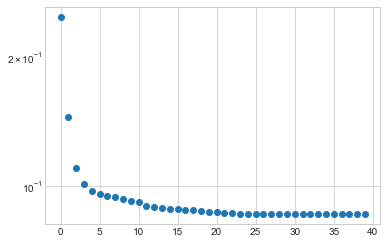

In [13]:
# Compute the true distance between the state and the space of positive Wigner operators
_, _, true_dist = wigner.wigner_fct(rho, n, d)
np.random.seed(0)
opt_data = optimize(wm_rho, true_dist, n, d)
plt.plot(opt_data, 'o')
plt.yscale('log')

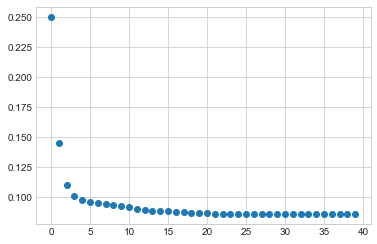

In [14]:
plt.plot(opt_data, 'o')

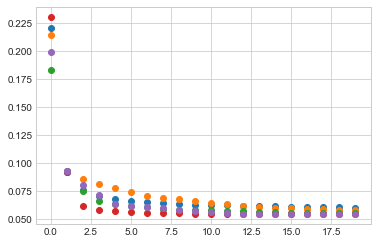

In [15]:
for i in range(5):
    opt_data_temp = optimize(wm_rho, true_dist, n, d, nswp = 10)
    plt.plot(opt_data_temp, 'o')

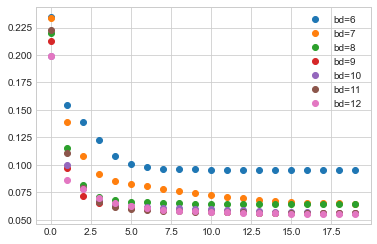

In [16]:
max_bd = 13
opt_data = [None]*max_bd
for bond_dim in range(6,max_bd):
    #TODO generate data in another jupyter block
    opt_data[bond_dim] = optimize(wm_rho, true_dist, n, d, bd = bond_dim, nswp = 10, opt_options={'maxfun':30000})
    plt.plot(opt_data[bond_dim], 'o', label='bd=' + repr(bond_dim))
    #plt.yscale('log')
plt.legend()

# Special states
## Random pure-ish states
Let's try looking at the magic vs. our measure for the state $S_1(\alpha)=\alpha\rho+\frac{(1-\alpha)}{d}I$, where $\rho$ is a random pure state. As we vary $\alpha$ from 0 to 1, the state should start to gain more magic as soon as it clears the stabilizer hull.

In [20]:
np.random.seed(0)
print(np.random.randint(10))
state = rand.random_mixed_state(n,d,M=1)
tests = [0,0.5,0.6]#,0.7,0.8,0.9,0.99]
opt_data = [None]*len(tests)
results = np.zeros((len(tests),5))
for i in range(len(tests)):
    alpha = tests[i]
    S = alpha*state + (1-alpha)/(d**2)*np.identity(d**2, dtype=np.complex128)
    S_wigner_mpo = state_to_wigner_mpo(S, n, d)
    _, M, N = wigner.wigner_fct(S, n, d)
    opt_data[i] = optimize(S_wigner_mpo, N, n, d, bd = 20, nswp = 20, opt_options={'maxfun':1000000})
    magic_estimate = opt_data[i][-1]
    results[i] = [alpha, M, N, magic_estimate, N - magic_estimate if magic_estimate != None else None]
    print(alpha, M, N, magic_estimate)

5


C:\Users\sharmalk\Documents\personal\mpo\wigner.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  W = W.astype(np.float64)


0 0.0 0.0 0.00019508869201253332
0.5 0.21926701284692648 0.06001166181153154 0.18004135055992548
0.6 0.31577282593839595 0.08131557682937843 0.24394814022690375


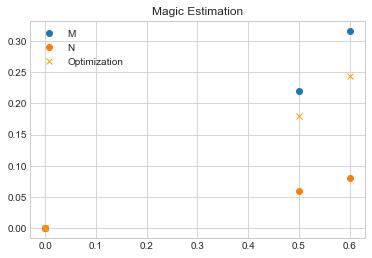

In [21]:
plt.plot(results[:,0],results[:,1],'o',label='M')
plt.plot(results[:,0],results[:,2],'o',label='N')
plt.plot(results[:,0],results[:,3],'x',color='orange',label='Optimization')
plt.title('Magic Estimation')
plt.legend()

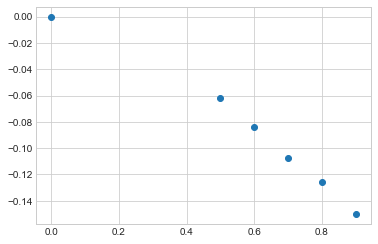

In [37]:
plt.plot(results[:,0],results[:,3],'o')

Why does $X$ have a complex wigner rep? Because it's not hermitian!

In [ ]:
import wigner
print(wigner.wigner_fct(wigner.X+wigner.X.conj().T, n=1, d=3))

## Corners of stabilizer hull
$S_2(\alpha)=\alpha\left|0,0><0,0\right|$ is not a state but it is a useful operator nevertheless becuase we know the distance to the hull, as the closest state to the hull is $S_2(1)$, so the distance is $D(\alpha)=\sqrt{\mathrm{Tr}[(\alpha-1)^2\left|0,0><0,0\right|^2]}=\alpha-1$. When $\alpha=1$, it is on the edge of the hull. As it moves outwards the distance increases linearly.

## Better version
That state actually always has 0 magic, because $W(\rho)$ is linear - this shows that the space of positive Wigner represented operators is actually more like a cone, not a bounded region. Instead consider this state: Mix two stabilizer states  $S_1$ and $S_2$ and walk in the negative direction of identity: $S(\alpha)=aS_1+bS_2-\alpha I$. The distance should be linear in $\alpha$! Chris thinks that $S(0)=aS_1+bS_2$ might not be the closest state to $S(\alpha)$ if you consider the higher dimensional space, unless the stabilizer hull is symmetric about the line connecting $S(\alpha)$ to $I$ - because then convexity of the hull gaurantees that $S(0)$ is the closest state. I'm not so sure about that. I also have to think about the fact that there are states with positive Wigner representation which are not in the hull. We're going to hit those states as we move in $\alpha$, perhaps in different ways depending on what $S_1$ and $S_2$ are.

In [15]:
state = np.zeros((d**n,d**n))
state[0,0] = 1
tests = [1,1.5,2,5,10,20]
opt_data = [None]*len(tests)
results = np.zeros((len(tests),5))
for i in range(len(tests)):
    alpha = tests[i]
    S = alpha*state
    S_wigner_mpo = state_to_wigner_mpo(S, n, d)
    _, M, N = wigner.wigner_fct(S, n, d)
    opt_data[i] = optimize(S_wigner_mpo, N, n, d, bd = 20, nswp = 20, opt_options={'maxfun':1000000})
    magic_estimate = opt_data[i][-1]
    results[i] = [alpha, M, N, magic_estimate, N - magic_estimate if magic_estimate != None else None]
    print(alpha, M, N, magic_estimate)

C:\Users\sharmalk\Documents\personal\mpo\wigner.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  W = W.astype(np.float64)


1 7.40148683083438e-17 1.7445471763153058e-17 5.954295930130369e-06
1.5 1.110223024625157e-16 2.6168207644729584e-17 2.921598288949817e-05
2 1.480297366166876e-16 3.4890943526306116e-17 1.6054657951233815e-05
5 3.7007434154171896e-16 8.722735881576527e-17 5.539128620348173e-05
10 7.401486830834379e-16 1.7445471763153054e-16 2.3691777888811603e-05
20 1.4802973661668758e-15 3.489094352630611e-16 3.988437133504651e-05


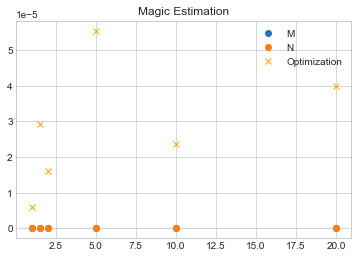

In [16]:
plt.plot(results[:,0],results[:,1],'o',label='M')
plt.plot(results[:,0],results[:,2],'o',label='N')
plt.plot(results[:,0],results[:,3],'x',color='orange',label='Optimization')
plt.title('Magic Estimation')
plt.legend()

## Truncated MPSs
- MPOs and MPSs with truncated bond dimensions: 
    - Create a random state
    - Turn it into an MPS with truncated bond dimension, or just do SVDs at each site and project onto the first n singular components
    - Then turn it into an MPO

In [17]:
state = rand.random_mixed_state(n,d)

### Need to debug: Issue with Wigner MPO for lightly mixed states
Wigner MPO isn't agreeing with the wigner function for random mixed states with M = 1 (pure) or M = 2. Here we see it failing on a pure state:

In [21]:
np.random.seed(0)
pure_state = rand.random_state(n,d)
state = rand.random_mixed_state(n, d, M=1) #Use only 1 pure state in the mix => pure state generated
state_wigner_mpo = state_to_wigner_mpo(state,n,d)

Generating an MPO in the original basis seems to work just fine on this state:

In [ ]:
pure_state_mpo = mpo.state_to_mpo(state, n, d)
mpo.check_coefficients(pure_state_mpo, state, n, d)

# Moving to larger systems (todo: phase space operators)
The Wigner function can be calculated directly from the MPO representation of $\rho$ like so: 
$W_\rho(u)=\sum_{a_k,b_k}\prod_k\rho^{(k)(a_k,b_k)}_{\alpha_k\alpha_{k+1}}\mathrm{Tr}[\left|a_k><b_k\right|A_{(u_k,v_k)}]$. Using Chris' notation, this can be expressed more simply:

$$W_\rho(u)=\sum_{a_k,b_k}\prod_k \rho^{(k)(a_k,b_k)}_{\alpha_k\alpha_{k+1}}\left<a_k,b_k|u_k,v_k\right)=\sum_{a_k,b_k}\prod_k \rho^{(k)(a_k,b_k)}_{\alpha_k\alpha_{k+1}}(A_{(u_k,v_k)})_{a_k,b_k}$$

In [ ]:
# TODO: Is there any way to get around doing a for loop here?
def better_wigner(mpo, n, d):
    W = np.zeros((d**(2*n)), dtype=np.complex128)
    M = 0. #old magic quantifier ("mana" in arxiv:1307.7171)
    N = 0. #new magic quantifier
    for u in range(d**(2*n)):
        index = np.unravel_index(u,tensor_shape)
        coefficient = np.identity(1,dtype=np.complex128)
        for i in range(n):
            coefficient = np.dot(coefficient, mpo[i][:,index[i],:])
        W[u] = 1./(d**n)*np.trace(np.dot(state,A_n[u]))
        if W[u].real < 0:
            M -= W[u].real
            N += (W[u].real)**2
    N = math.sqrt(N)
    return W, M, N
            

# Reorganization of code to run tests at arbitrary n
TODO

In [ ]:
def test_optimization(n, d):
    state = random_mixed_state(n, d)
    mpo = state_to_mpo(state, n, d)
    
    # n-dimensional phase space operators:
    A_n = np.zeros((d**(2*n),d**n,d**n),dtype=np.complex128)
    tensor_shape = tuple([d**2]*n)
    for u in range(d**(2*n)):
        index = np.unravel_index(u,tensor_shape)
        temp = np.identity(1,dtype=np.complex128)
        for i in range(n):
            temp = np.kron(temp, A[index[i]])
        A_n[u] = temp
    
    wigner_mpo = state_to_wigner_mpo(state, n, d, A_n)
    _, _, true_dist = wigner(rho, n, d, A_n)
    opt_data = optimize(wigner_mpo, true_dist, n, d)
    plt.plot(opt_data)
    
test_optimization(5, 3)

# Debugging: Trying to change basis to phase space
Unfortunately, the squared distance comes out to be complex, which isn't good.. let's try to debug:

In [ ]:
#mA = gen_mpo(n,d**2,10)
norm = d**n
mB = m_rho_ps
#print(inner_prod(mA,mA,norm))
print(inner_prod(mB,mB,norm))
#print(inner_prod(mA,mB,norm))
print("Magnitude of complex value: " + repr(np.amax( [np.amax(np.abs(np.imag(mB[j]) ) ) for j in range(n) ] )))

# Check that an mpo in the phase space basis represents a hermitian operator
def check_real_coefficients(mpo):
    good = True
    tensor_shape = tuple([d**2]*n)
    for u in range(d**(2*n)):
        index = np.unravel_index(u,tensor_shape)
        coefficient = np.identity(1,dtype=np.complex128)
        for i in range(n):
            coefficient = np.dot(coefficient, mpo[i][:,index[i],:])
        if (coefficient[0][0].imag > 1e-16):#TODO: should really be comparing ratio of .imag to .real
            good = False
            print("Coefficient " + repr(index) + " is complex with value " + repr(coefficient[0][0]))
    if good:
        print("Coefficents were all real!")
        
#check_real_coefficients(mA)
check_real_coefficients(mB)


Is my random state even hermitian? What's going on here..

In [ ]:
print(np.allclose(rho,rho.T.conj()))

Ok... what about the Wigner function? Does it agree with these coefficients?

In [ ]:
check_against_wigner(mB, rho)

No! TODO: This needs to be debugged!